In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
os.system('pip install protobuf==3.20.*')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires p

0

In [4]:
import librosa
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, 
    Reshape, LSTM, Dense, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

2025-11-16 04:31:58.345479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763267518.600420      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763267518.665032      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
def create_dataset_dataframe(dataset_path):
    """
    Parses the RAVDESS dataset filenames to create a structured DataFrame.
    """
    emotion_map = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    data = []
    print(f"Parsing dataset from: {dataset_path}")
    
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path does not exist: {dataset_path}")
        return None

    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith(".wav"):
                    parts = file_name.split(".")[0].split("-")
                    if len(parts) == 7:
                        emotion_code = parts[2]
                        actor_id = parts[6]
                        file_path = os.path.join(actor_path, file_name)
                        emotion_label = emotion_map.get(emotion_code)
                        if emotion_label:
                            data.append({
                                "filepath": file_path,
                                "actor": actor_id,
                                "emotion": emotion_label
                            })
    
    if not data:
        print("\nError: No data was loaded. Please check the dataset path.")
        return None
        
    df = pd.DataFrame(data)
    print(f"\nDataFrame with {len(df)} entries.")
    return df

In [10]:
def extract_features(file_path, augment=False):
    """
    Extracts Mel Spectrogram AND aggregated features (MFCC, Chroma, ZCR) from an audio file.
    Optionally applies augmentation.
    """
    try:
        signal, sample_rate = librosa.load(file_path, sr=22050)
        
        if augment:
            # 1. Noise Injection
            noise_amp = 0.005 * np.random.uniform() * np.amax(signal)
            signal = signal + noise_amp * np.random.normal(size=signal.shape[0])
            
            # 2. Time Shifting
            shift_range = int(np.random.uniform(low=-5, high=5) * (sample_rate / 1000))
            signal = np.roll(signal, shift_range)
            
            # 3. Pitch Shifting
            pitch_shift = np.random.uniform(low=-1, high=1)
            signal = librosa.effects.pitch_shift(y=signal, sr=sample_rate, n_steps=pitch_shift)
            
            # 4. Time Stretching
            stretch_rate = np.random.uniform(low=0.9, high=1.1)
            signal = librosa.effects.time_stretch(y=signal, rate=stretch_rate)
        
        # Extract Mel Spectrogram (for deep learning models)
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
        
        # Extract aggregated features (for traditional ML models)
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        zcr = librosa.feature.zero_crossing_rate(y=signal)
        
        # Aggregate by taking mean across time
        mfccs_mean = np.mean(mfccs, axis=1)
        chroma_mean = np.mean(chroma, axis=1)
        zcr_mean = np.mean(zcr, axis=1)
        
        # Combine into single feature vector
        aggregated_features = np.hstack([mfccs_mean, chroma_mean, zcr_mean])
        
        return mel_spectrogram, aggregated_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

In [11]:
def build_feature_dataframe(dataset_path):
    """
    Creates the main DataFrame and extracts features for all files.
    """
    ravdess_df = create_dataset_dataframe(dataset_path)
    if ravdess_df is None:
        return None

    print("\nExtracting features from audio files... (This may take a few minutes)")
    
    # Extract both mel spectrograms and aggregated features
    tqdm.pandas(desc="Extracting Features")
    ravdess_df[['mel_spectrogram', 'aggregated_features']] = ravdess_df['filepath'].progress_apply(
        lambda filepath: pd.Series(extract_features(filepath, augment=False))
    )
    
    ravdess_df.dropna(inplace=True)
    print("\n Feature extraction complete.")
    return ravdess_df

In [13]:
DATASET_PATH = "/kaggle/input/ravdess-audio-only/DATASET"

In [23]:
df.head()

,filepath,actor,emotion,mel_spectrogram,aggregated_features
0,/kaggle/input/ravdess-audio-only/DATASET/Actor...,01,calm,"[[4.9420542e-08, 1.0147319e-07, 1.4144265e-08,...","[-698.6376953125, 68.6985855102539, 1.10036838..."
1,/kaggle/input/ravdess-audio-only/DATASET/Actor...,01,neutral,"[[2.5969036e-09, 1.088343e-09, 8.878012e-10, 4...","[-692.8557739257812, 55.36389923095703, -1.548..."
2,/kaggle/input/ravdess-audio-only/DATASET/Actor...,01,sad,"[[4.3227405e-10, 6.692143e-10, 1.2675191e-09, ...","[-627.470458984375, 50.89054489135742, -4.8933..."
3,/kaggle/input/ravdess-audio-only/DATASET/Actor...,01,calm,"[[1.5230579e-06, 1.1671749e-06, 2.4733458e-07,...","[-704.5413208007812, 68.82943725585938, 4.7289..."
4,/kaggle/input/ravdess-audio-only/DATASET/Actor...,01,calm,"[[4.4146126e-10, 1.5210988e-08, 1.9769658e-08,...","[-697.1661987304688, 65.10820007324219, 0.9303..."


In [24]:
df.sample(10)

,filepath,actor,emotion,mel_spectrogram,aggregated_features
502,/kaggle/input/ravdess-audio-only/DATASET/Actor...,09,calm,"[[1.9858028e-08, 6.980216e-08, 2.3468063e-07, ...","[-712.0098876953125, 64.44874572753906, 1.3877..."
953,/kaggle/input/ravdess-audio-only/DATASET/Actor...,16,neutral,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1485914e-27,...","[-636.2108764648438, 44.557125091552734, 5.051..."
1213,/kaggle/input/ravdess-audio-only/DATASET/Actor...,21,surprised,"[[7.643999e-07, 9.303394e-06, 2.336406e-05, 5....","[-504.055419921875, 45.97423553466797, -5.8019..."
1096,/kaggle/input/ravdess-audio-only/DATASET/Actor...,19,surprised,"[[8.018484e-05, 0.0002518732, 0.00026488805, 0...","[-744.6863403320312, 67.08153533935547, 18.314..."
1321,/kaggle/input/ravdess-audio-only/DATASET/Actor...,23,calm,"[[3.040098e-15, 7.457423e-11, 8.02885e-10, 1.3...","[-652.316650390625, 59.99892807006836, 0.20387..."
728,/kaggle/input/ravdess-audio-only/DATASET/Actor...,13,surprised,"[[9.432829e-07, 1.0780528e-06, 8.4835307e-07, ...","[-612.001708984375, 55.13935089111328, -2.2007..."
847,/kaggle/input/ravdess-audio-only/DATASET/Actor...,15,fearful,"[[6.0400344e-05, 0.00010629241, 4.472672e-05, ...","[-489.2159423828125, 41.8719596862793, -9.9696..."
1091,/kaggle/input/ravdess-audio-only/DATASET/Actor...,19,disgust,"[[8.014209e-06, 2.9391476e-05, 0.000115301824,...","[-611.4188842773438, 70.55178833007812, 13.218..."
810,/kaggle/input/ravdess-audio-only/DATASET/Actor...,14,happy,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-470.8772888183594, 12.603251457214355, -29.5..."
247,/kaggle/input/ravdess-audio-only/DATASET/Actor...,05,disgust,"[[8.09309e-06, 2.0316333e-05, 1.7929786e-05, 6...","[-727.1077880859375, 55.8419075012207, 11.0689..."


In [25]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds the original, more powerful 2D CNN model with stronger Dropout.
    """
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn_lstm_model(input_shape, num_classes):
    """
    Builds the original, more powerful CNN-LSTM model with stronger Dropout.
    """
    input_layer = Input(shape=input_shape)

    # Conv Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Reshape for LSTM
    conv_output_shape = x.shape[1:]
    new_shape = (conv_output_shape[0] * conv_output_shape[1], conv_output_shape[2])
    x = Reshape(new_shape)(x)

    # LSTM layers
    x = LSTM(128, return_sequences=False, dropout=0.4)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
class AttentionLayer(Layer):
    """
    Custom Keras Attention Layer for sequence models.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                shape=(input_shape[-1], input_shape[-1]),
                                initializer='glorot_uniform',
                                trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                shape=(input_shape[-1],),
                                initializer='zeros',
                                trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [27]:
def build_cnn_lstm_attention_model(input_shape, num_classes):
    """
    Builds the original, more powerful CNN-LSTM with Attention model.
    """
    input_layer = Input(shape=input_shape)

    # Conv Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Reshape for LSTM
    conv_output_shape = x.shape[1:]
    new_shape = (conv_output_shape[0] * conv_output_shape[1], conv_output_shape[2])
    x = Reshape(new_shape)(x)

    # LSTM layers (must return sequences for Attention)
    x = LSTM(128, return_sequences=True, dropout=0.4)(x)

    # Attention Layer
    x = AttentionLayer()(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [28]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    """
    Trains and evaluates a single model, returning its history and test score.
    """
    
    # Define callbacks to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=20,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                  factor=0.2, 
                                  patience=5,
                                  min_lr=0.00001)
    
    print(f"\n--- Starting Model Training: {model_name} ---")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print(f"\n--- Evaluating {model_name} on Test Set ---")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate classification report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
    
    return history, (test_loss, test_accuracy), y_pred


In [14]:
df = build_feature_dataframe(DATASET_PATH)

Parsing dataset from: /kaggle/input/ravdess-audio-only/DATASET

DataFrame with 1440 entries.

Extracting features from audio files... (This may take a few minutes)


Extracting Features: 100%|██████████| 1440/1440 [01:17<00:00, 18.67it/s]


 Feature extraction complete.


In [15]:
MAX_PAD_LEN = 174
AUGMENTATION_FACTOR = 2

In [16]:
def pad_spectrogram(spec, max_len):
        """Pads or truncates a spectrogram to a max length."""
        if spec.shape[1] > max_len:
            return spec[:, :max_len]
        else:
            padding = max_len - spec.shape[1]
            return np.pad(spec, ((0, 0), (0, padding)), mode='constant')

In [17]:
X_padded = np.array([pad_spectrogram(s, MAX_PAD_LEN) for s in df['mel_spectrogram'].tolist()])
X_reshaped = X_padded[..., np.newaxis]

# Extract aggregated features for traditional ML models
X_aggregated = np.array(df['aggregated_features'].tolist())

global label_encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['emotion'])
num_classes = len(label_encoder.classes_)

print(f"\nData prepared: X_reshaped shape={X_reshaped.shape}, X_aggregated shape={X_aggregated.shape}, y shape={y_encoded.shape}")

# --- 3. Actor-Independent Split ---
actor_ids = df['actor'].unique()
train_actors, test_actors = train_test_split(actor_ids, test_size=0.15, random_state=42)
train_actors, val_actors = train_test_split(train_actors, test_size=(0.15/0.85), random_state=42)

train_indices = df['actor'].isin(train_actors)
val_indices = df['actor'].isin(val_actors)
test_indices = df['actor'].isin(test_actors)

# Create base splits for deep learning (non-augmented)
X_train_base, y_train_base = X_reshaped[train_indices], y_encoded[train_indices]
X_val, y_val = X_reshaped[val_indices], y_encoded[val_indices]
X_test, y_test = X_reshaped[test_indices], y_encoded[test_indices]

# Create splits for traditional ML models
X_train_ml, y_train_ml = X_aggregated[train_indices], y_encoded[train_indices]
X_test_ml, y_test_ml = X_aggregated[test_indices], y_encoded[test_indices]



Data prepared: X_reshaped shape=(1440, 128, 174, 1), X_aggregated shape=(1440, 53), y shape=(1440,)


In [18]:
X_train_augmented = []
y_train_augmented = []

train_df = df[train_indices]

for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting"):
    # 1. Add the Original
    X_train_augmented.append(pad_spectrogram(row['mel_spectrogram'], MAX_PAD_LEN))
    y_train_augmented.append(row['emotion'])
    
    # 2. Add augmented copies
    for _ in range(AUGMENTATION_FACTOR):
        aug_spec, _ = extract_features(row['filepath'], augment=True)
        if aug_spec is not None:
            X_train_augmented.append(pad_spectrogram(aug_spec, MAX_PAD_LEN))
            y_train_augmented.append(row['emotion'])
        
X_train = np.array(X_train_augmented)[..., np.newaxis]
y_train = label_encoder.transform(y_train_augmented)

Augmenting: 100%|██████████| 960/960 [03:50<00:00,  4.16it/s]


In [19]:
# Scale features for SVM
scaler = StandardScaler()
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

# --- SVM Model ---
svm_model = SVC(kernel='rbf', C=4, random_state=42)
svm_model.fit(X_train_ml_scaled, y_train_ml)
svm_predictions = svm_model.predict(X_test_ml_scaled)
svm_accuracy = np.mean(svm_predictions == y_test_ml)

print(f"\nSVM Test Accuracy: {svm_accuracy * 100:.2f}%")
print("\nSVM Classification Report:")
print(classification_report(y_test_ml, svm_predictions, target_names=label_encoder.classes_, zero_division=0))



SVM Test Accuracy: 35.83%

SVM Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.72      0.62        32
        calm       0.28      0.50      0.36        32
     disgust       0.50      0.19      0.27        32
     fearful       0.41      0.47      0.43        32
       happy       0.35      0.22      0.27        32
     neutral       0.25      0.12      0.17        16
         sad       0.23      0.38      0.29        32
   surprised       0.42      0.16      0.23        32

    accuracy                           0.36       240
   macro avg       0.37      0.34      0.33       240
weighted avg       0.38      0.36      0.34       240



In [20]:
# --- Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=20, random_state=42)
rf_model.fit(X_train_ml_scaled, y_train_ml)
rf_predictions = rf_model.predict(X_test_ml_scaled)
rf_accuracy = np.mean(rf_predictions == y_test_ml)

print(f"\nRandom Forest Test Accuracy: {rf_accuracy * 100:.2f}%")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_ml, rf_predictions, target_names=label_encoder.classes_, zero_division=0))


Random Forest Test Accuracy: 36.67%

Random Forest Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.62      0.54        32
        calm       0.35      0.84      0.49        32
     disgust       0.28      0.28      0.28        32
     fearful       0.50      0.22      0.30        32
       happy       0.47      0.28      0.35        32
     neutral       0.00      0.00      0.00        16
         sad       0.27      0.31      0.29        32
   surprised       0.43      0.19      0.26        32

    accuracy                           0.37       240
   macro avg       0.35      0.34      0.32       240
weighted avg       0.37      0.37      0.34       240



In [21]:
histories = {}
scores = {}
predictions = {}

input_shape = X_train.shape[1:]

In [29]:
# --- Model 1: CNN ---
print("--- MODEL 1: CNN ---")
print("="*70)
model_cnn = build_cnn_model(input_shape, num_classes)
model_cnn.summary()
hist_cnn, score_cnn, pred_cnn = train_and_evaluate_model(
    model_cnn, X_train, y_train, X_val, y_val, X_test, y_test, "CNN"
)
histories['CNN'] = hist_cnn
scores['CNN'] = score_cnn
predictions['CNN'] = pred_cnn

--- MODEL 1: CNN ---


I0000 00:00:1763268384.381526      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,216 (430.53 KB)

 Trainable params: 110,216 (430.53 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN ---
Epoch 1/200


I0000 00:00:1763268389.380687     173 service.cc:148] XLA service 0x44b9c3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763268389.381557     173 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763268389.717393     173 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1633 - loss: 2.0939

I0000 00:00:1763268394.418083     173 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2023 - loss: 2.0338 - val_accuracy: 0.2375 - val_loss: 1.9646 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2332 - loss: 1.9423 - val_accuracy: 0.2917 - val_loss: 1.9701 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2227 - loss: 1.9173 - val_accuracy: 0.2958 - val_loss: 1.9607 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2492 - loss: 1.8644 - val_accuracy: 0.2292 - val_loss: 1.9166 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2613 - loss: 1.8245 - val_accuracy: 0.2250 - val_loss: 1.9141 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2890 - loss: 1.8013 - val_accuracy: 0.2458 - val_loss: 1.9238 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2783 - loss: 1.7929 - val_accurac

In [30]:
# --- Model 2: CNN-LSTM ---
print("--- MODEL 2: CNN-LSTM ---")
print("="*70)
model_cnn_lstm = build_cnn_lstm_model(input_shape, num_classes)
model_cnn_lstm.summary()
hist_cnn_lstm, score_cnn_lstm, pred_cnn_lstm = train_and_evaluate_model(
    model_cnn_lstm, X_train, y_train, X_val, y_val, X_test, y_test, "CNN-LSTM"
)
histories['CNN-LSTM'] = hist_cnn_lstm
scores['CNN-LSTM'] = score_cnn_lstm
predictions['CNN-LSTM'] = pred_cnn_lstm

--- MODEL 2: CNN-LSTM ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1376, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,408 (493.78 KB)

 Trainable params: 126,408 (493.78 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN-LSTM ---
Epoch 1/200


E0000 00:00:1763268488.255630      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.1321 - loss: 2.0755 - val_accuracy: 0.1333 - val_loss: 2.0633 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.1323 - loss: 2.0557 - val_accuracy: 0.2208 - val_loss: 2.0235 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.1715 - loss: 2.0115 - val_accuracy: 0.2208 - val_loss: 1.9636 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.2239 - loss: 1.9432 - val_accuracy: 0.2333 - val_loss: 1.9547 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.2225 - loss: 1.9262 - val_accuracy: 0.2417 - val_loss: 1.9382 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.2274 - loss: 1.9259 - val_accuracy: 0.2250 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2415 - loss: 1.9047 - val_accurac

In [31]:
# --- Model 3: CNN-LSTM-Attention ---
print("--- MODEL 3: CNN-LSTM-Attention ---")
model_cnn_lstm_att = build_cnn_lstm_attention_model(input_shape, num_classes)
model_cnn_lstm_att.summary()
hist_cnn_lstm_att, score_cnn_lstm_att, pred_cnn_lstm_att = train_and_evaluate_model(
    model_cnn_lstm_att, X_train, y_train, X_val, y_val, X_test, y_test, "CNN-LSTM-Attention"
)
histories['CNN-LSTM-Attention'] = hist_cnn_lstm_att
scores['CNN-LSTM-Attention'] = score_cnn_lstm_att
predictions['CNN-LSTM-Attention'] = pred_cnn_lstm_att

--- MODEL 3: CNN-LSTM-Attention ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │        16,512 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,544 (974.78 KB)

 Trainable params: 249,544 (974.78 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training: CNN-LSTM-Attention ---
Epoch 1/200


E0000 00:00:1763268965.364981      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_7_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.1953 - loss: 1.9739 - val_accuracy: 0.2375 - val_loss: 1.9020 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2707 - loss: 1.8448 - val_accuracy: 0.2208 - val_loss: 1.9225 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2739 - loss: 1.8221 - val_accuracy: 0.2625 - val_loss: 1.9412 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2735 - loss: 1.8068 - val_accuracy: 0.2500 - val_loss: 1.9182 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2865 - loss: 1.8015 - val_accuracy: 0.2458 - val_loss: 1.9192 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2964 - loss: 1.7841 - val_accuracy: 0.3125 - val_loss: 1.8718 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2938 - loss: 1.7574 - val_accuracy

In [32]:
scores['SVM'] = (0, svm_accuracy)
scores['Random Forest'] = (0, rf_accuracy)
predictions['SVM'] = svm_predictions
predictions['Random Forest'] = rf_predictions

# --- 7. Final Comparison ---
print("\n" + "="*70)
print("--- FINAL MODEL COMPARISON ---")
print("="*70)

results_df = pd.DataFrame({
    'Model': list(scores.keys()),
    'Test Accuracy': [s[1] * 100 for s in scores.values()]
}).sort_values(by='Test Accuracy', ascending=False)

print(results_df.to_string(index=False, float_format="%.2f"))



--- FINAL MODEL COMPARISON ---
             Model  Test Accuracy
     Random Forest          36.67
               SVM          35.83
CNN-LSTM-Attention          35.00
          CNN-LSTM          26.25
               CNN          23.75


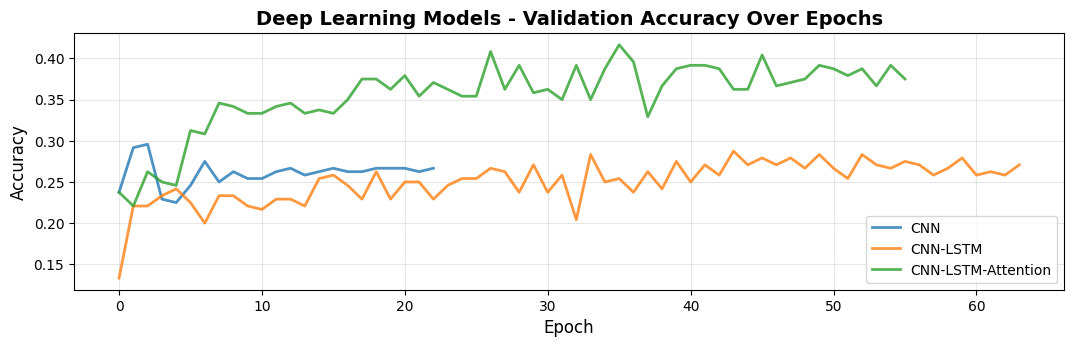

In [33]:
# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Validation Accuracy Comparison (Deep Learning Models)
ax1 = fig.add_subplot(gs[0, :2])
for model_name, history in histories.items():
    val_acc = history.history['val_accuracy']
    ax1.plot(val_acc, label=f'{model_name}', linewidth=2, alpha=0.8)
ax1.set_title('Deep Learning Models - Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

In [34]:
# Plot 2: Bar Chart - All Models Comparison
ax2 = fig.add_subplot(gs[0, 2])
models = results_df['Model'].tolist()
accuracies = results_df['Test Accuracy'].tolist()
colors = ['#FF6B6B' if acc < 50 else '#4ECDC4' if acc < 70 else '#95E1D3' for acc in accuracies]
ax2.barh(models, accuracies, color=colors, alpha=0.8)
ax2.set_xlabel('Test Accuracy (%)', fontsize=12)
ax2.set_title('Overall Model Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracies):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)
dl_models = ['CNN', 'CNN-LSTM', 'CNN-LSTM-Attention']
for idx, model_name in enumerate(dl_models):
    ax = fig.add_subplot(gs[1, idx])
    history = histories[model_name]
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    
    ax.plot(epochs, train_loss, label='Training Loss', linewidth=2, alpha=0.8)
    ax.plot(epochs, val_loss, label='Validation Loss', linewidth=2, alpha=0.8)
    ax.set_title(f'{model_name} - Loss Curves', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

In [35]:
top_3_models = results_df.head(3)['Model'].tolist()
for idx, model_name in enumerate(top_3_models):
    ax = fig.add_subplot(gs[2, idx])
    cm = confusion_matrix(y_test if model_name in dl_models else y_test_ml, 
                        predictions[model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_,
               ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_title(f'{model_name} - Confusion Matrix\nAcc: {scores[model_name][1]*100:.1f}%', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)

plt.suptitle('Speech Emotion Recognition - Comprehensive Model Analysis', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

<Figure size 640x480 with 0 Axes>

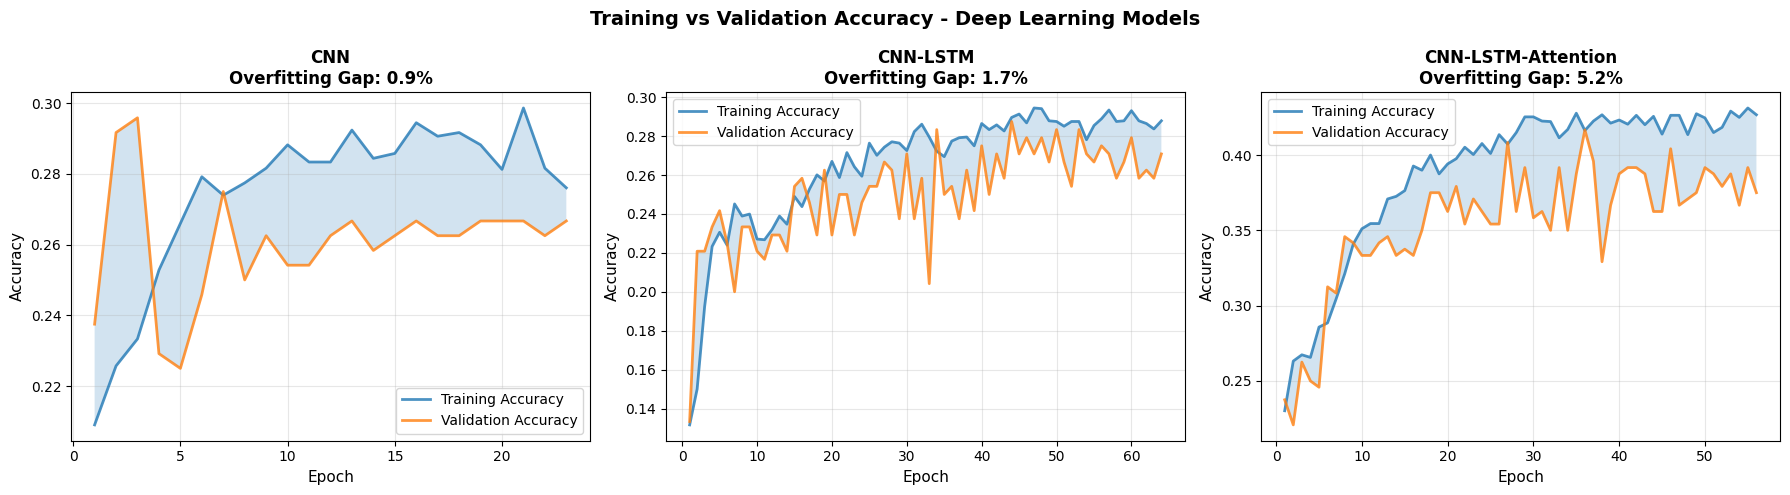

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, model_name in enumerate(dl_models):
    history = histories[model_name]
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    axes[idx].plot(epochs, train_acc, label='Training Accuracy', linewidth=2, alpha=0.8)
    axes[idx].plot(epochs, val_acc, label='Validation Accuracy', linewidth=2, alpha=0.8)
    axes[idx].fill_between(epochs, train_acc, val_acc, alpha=0.2)
    axes[idx].set_title(f'{model_name}\nOverfitting Gap: {(train_acc[-1] - val_acc[-1])*100:.1f}%', 
                      fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('Accuracy', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Training vs Validation Accuracy - Deep Learning Models', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()